Я выбрала экспрессив crazy. Предполагаемый профиль экспрессива  U-образный, поскольку экспрессив имеет сильную эмоциональную окраску, которая более присуща полярным контекстам (ярко негативные, ярко позитивные) например:

stop watching your **crazy** movies all day! it's time to get busy (негативный)

it was a **crazy** day! We had a great time! (позитивный )

 и наоборот в нейтральных контекстах встречается реже 
 
 **crazy** granny lived in a nursing home


In [7]:
import pandas as pd
import json
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
import string
import re
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
!gzip -d /content/reviews_Amazon_Instant_Video_5.json.gz

In [4]:
datas = []
with open('/content/reviews_Amazon_Instant_Video_5.json', 'r') as f:
  file = f.readlines()
  for i in file:
    st = i.replace("'", '')
    st = json.loads(st)
    datas.append(st)

In [5]:
len(datas)

37126

In [6]:
# создание датасета
df = pd.DataFrame(columns = ['overall', 'reviewText'])
for ind, line in enumerate(datas):
  if 'crazy' in line['reviewText'].split(' '):
    text = re.sub(r"[#$%&\'()*+,-./:;<=>?@\^_`{|}~]", '', line['reviewText']) 
    line['tokens'] = tknzr.tokenize(text)
    df.loc[ind, 'reviewText'] = line['reviewText']
    df.loc[ind, 'overall'] = line['overall']
df

,overall,reviewText
44,5,Who says the sitcom is dead? Not since Arrest...
162,5,"Im not crazy about my son watching TV, but I m..."
420,4,Its always difficult starting a review you kno...
458,5,4.7 starsThis show is excellent mainly due to ...
605,5,This season is basiclly the exact same as with...
...,...,...
36753,3,"A feel good movie, that is if you manage to wa..."
36967,3,The season so far is crazy people coming toget...
37044,5,I saw The Descent a while back and thought it ...
37112,2,"Well, the word sabotage reminds me of the grea..."


In [ ]:
# df.to_excel('dataset.xlsx')

В качестве основы для создания корпуса я взяла корпус данных [Amazon Instant Video](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz) В этом корпусе каждый комментарий имеет оценку продукта от 1 до 5, где 1 - негативная оценка, а 5 - позитивная. Из него я сформировала подкорпус содержащий анализируемый экспрессив crazy и оценку продукта

In [8]:
def count_labels (i, countR, countX, index):
  if i['overall'] == index and 'tokens' in i.keys():
    countR += len([x for x in i['tokens'] if len(x) == len('crazy') and x != 'crazy'])
    countX += len(re.findall(r'crazy', i['reviewText']))
  return countX, countR

In [9]:
list_logs = []
countR = 0
countX = 0
for index in range(1, 6):
  for i in datas:
    if i['overall'] == index and 'tokens' in i.keys():
      countX, countR = count_labels (i, countR, countX, index)
  list_logs.append(np.log(countX/(countR - countX)))

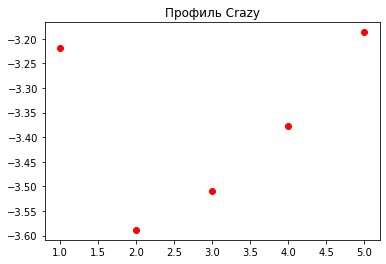

In [10]:
plt.title('Профиль Crazy')
plt.plot([1,2,3,4, 5], list_logs,'ro')
plt.show()

In [24]:
X = np.array([1,2,3,4, 5])
y = np.array(list_logs)

In [44]:
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    #calculate r-squared
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = ssreg / sstot

    return results
print('Значение R² для квадратичной регрессии', polyfit(X, y, 2)['r_squared'])


from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(np.array([1,2,3,4, 5]).reshape(-1, 1), np.array(list_logs).reshape(-1, 1))
y_pred = slr.predict(np.array([1,2,3,4, 5]).reshape(-1, 1))
print("Значение R² для линейной регрессии", slr.score(np.array([1,2,3,4, 5]).reshape(-1, 1, ), np.array(list_logs).reshape(-1, 1)))

Значение R² для квадратичной регрессии 0.8590220200786484
Значение R² для линейной регрессии 0.06083371062663745


В соответствии с R² наши данные лучше описывает квадратичная регрессия

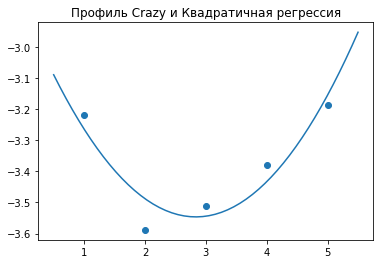

In [45]:
model = np.poly1d(np.polyfit(X, y, 2))
plt.title('Профиль Crazy и Квадратичная регрессия')
polyline = np.linspace(0.5,  5.5)
plt.scatter(X, y)
plt.plot(polyline, model(polyline))

In [57]:
df[df['overall'] == 1]['reviewText'][:3].tolist()

['I have very mixed emotions over this latest entry into the long-running and much-beloved Stargate franchise. I fondly remember seeing the original movie at the theater and was immediately impressed by its imagination. As it evolved into a weekly series I watched as my sons grew and became enthralled in the story line with me. And yes, we even liked "Atlantis".The Syfy channel promoted this show as an "edgier" Stargate. I found that this did not work for me. The very elements that made the original movie and following 15 seasons so enjoyable was now totally lost in this self-inflicted reinvention. Stories that were once fun, adventurous, full of camaraderie & humor were now jettisoned in favor of a grittier, darker, gloomier, smuttier and meandering approach.Some shows can evolve successfully. What we had here was the results of a very bad miss-calculation by MGM Television in canceling "Atlantis". And then upon realizing their mistake the panic-ridden response to rectify this error b

В результате получился U-образный профиль, с перевесом данных в сторону позитивных оценок (4, 5).

Пример (оценка 1)

my kid put this on, but i would not pick it myself, you dont really learn anything from this show, just **crazy** characters doing goofy stuff.  i rather my kid watch something where they learn, like dinosaur train or sid the science kid.

Пример (оценка 3)

Call me **crazy** (go ahead, do it), but a town dominated by a bunch of grown men who all dress like bikers and commit crimes is about as credible as a white-collar married father-of-three being a massive pothead well into his forties.  Lets get real. ...

Пример (оценка 5)

... all of whom own and run an Irish bar in downtown Philadelphia.  They get into all kinds of **crazy** hijinks through misunderstandings and just plain bad judgement, ranging from being mistaken as a gay bar to Charlie lying about having cancer. ...



Проблема этого подхода заключается в том, что бывают примеры, когда экспрессив имеет позитивную тональноть, а сам комментарий негативную или наоборот. Особенное это часто встречается в длинных комментарях. 

Например:
I have very mixed emotions over this latest entry into the long-running and much-beloved Stargate franchise.<...>
I just waited till Amazon had a **crazy** sale to buy them.

Этот комментарий имеет оценку 1. Между первой и второй фразой следует длинное описание мнения автора. Из этого примера мы видим, что слово crazy никак не связано с оценкой автора, и скорее имеет противоположную коннотацию, поскольку описывает не просмотренный фильм, а скидки. 